In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm

import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import shap

import math

from lib import *

In [40]:
pd.options.display.float_format = '{:,.2f}'.format
# plt.style.use('dark_background')
sns.set_theme(style="whitegrid", palette="muted")
sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [41]:
WORK_DIR = 'working_data'
FILE_NAME = 'df_work_ds_final.zip'

In [42]:
filepath = Path(f'./{WORK_DIR}/{FILE_NAME}')
df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [43]:
columns_drop = [
    "Fel_1",
    "Fel_2",
    "D_SL",
    "O2_tot",
    "Sl_tot",
    "AC_rbk_open",
    "AC_valve_open",
    "P_O2_in",
    # "P_tot_2",
    "FT1_level",
    "FT1_P",
    "FT1_T_in",
    "FT1_T",
    "FT2_level",
    "FT2_P",
    "FT2_T",
    "Cond_Q",
    "Cond_level",
    "Cond_valve",
    "O2_conc_1",
    "O2_conc_2",
    'T_C1',
    'T_C2',
    'T_C3',
    'T_C4',
    'T_C5'
]

df.drop(columns_drop, inplace=True, axis=1)

In [44]:
# df['Fe2+'] = df['Fe2+'].shift(2)
# df.dropna(axis=0, inplace=True)

df['lag_1'] = df['Fe2+'].shift(1)
df['lag_2'] = df['Fe2+'].shift(2)
df['lag_3'] = df['Fe2+'].shift(3)
df['lag_4'] = df['Fe2+'].shift(4)
df['lag_5'] = df['Fe2+'].shift(5)

df.dropna(axis=0, inplace=True)

In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
QQ_C1,"11,481.00",18.39,6.90,0.00,14.14,19.82,22.87,31.43
QQ_C2,"11,481.00",30.16,6.12,0.10,26.12,30.37,34.52,44.38
QQ_C3,"11,481.00",16.30,3.69,0.00,15.58,17.29,18.38,21.73
QQ_C4,"11,481.00",5.53,2.11,0.01,4.21,5.49,7.07,11.89
QQ_C5,"11,481.00",2.13,1.61,0.00,0.91,1.97,2.87,7.64
QQ_tot,"11,481.00",72.51,13.84,0.79,68.10,73.88,82.36,97.32
O2_C1,"11,481.00","2,160.63",325.31,0.00,"1,939.74","2,159.04","2,398.46","3,046.64"
O2_C2,"11,481.00","1,960.93",283.09,0.00,"1,777.06","1,927.79","2,180.31","2,705.14"
O2_C3,"11,481.00",999.54,188.31,0.00,891.98,971.72,"1,113.00","1,598.46"
O2_C4,"11,481.00",380.75,107.75,0.00,342.18,381.91,429.93,850.34


In [46]:
X = df.drop(['Fe2+'], axis=1)
y = df['Fe2+']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=False)

In [48]:
for col in X_train.columns:
    smooth_data_moving_average(X_train[col], window=12)

smooth_data_moving_average(y_train, window=12)

for col in X_test.columns:
   smooth_data_moving_average(X_test[col], window=12)

smooth_data_moving_average(y_test, window=12)

In [49]:
clf = make_pipeline(
    StandardScaler(),
    # ElasticNet()
    Ridge()
)

Метрики качества
RMSE: 0.3114
MAE: 0.2041
R2: 0.5051


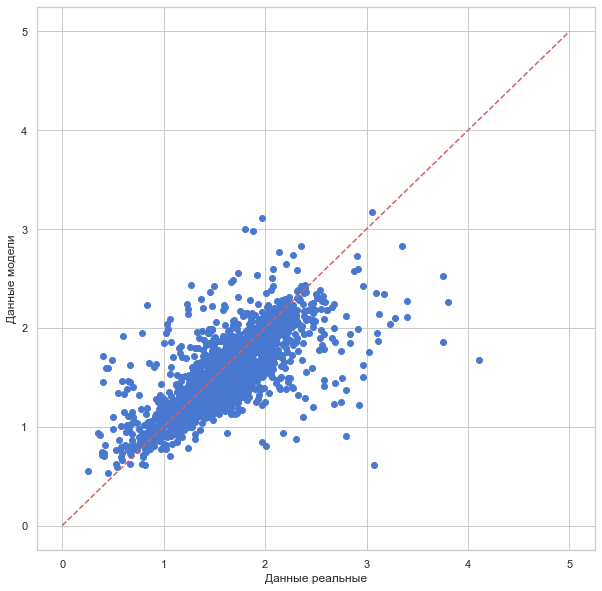

In [50]:
clf.fit(X_train, y_train)
model_score(clf, X_test, y_test)

In [51]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(train_data)

Learning rate set to 0.057919
0:	learn: 0.4985119	total: 23.8ms	remaining: 23.8s
1:	learn: 0.4798038	total: 28.4ms	remaining: 14.2s
2:	learn: 0.4620753	total: 35.1ms	remaining: 11.7s
3:	learn: 0.4453112	total: 40.1ms	remaining: 9.98s
4:	learn: 0.4296100	total: 44.6ms	remaining: 8.88s
5:	learn: 0.4146137	total: 51ms	remaining: 8.44s
6:	learn: 0.4007624	total: 55.8ms	remaining: 7.92s
7:	learn: 0.3877842	total: 60.1ms	remaining: 7.45s
8:	learn: 0.3762633	total: 65.9ms	remaining: 7.25s
9:	learn: 0.3651449	total: 70.4ms	remaining: 6.97s
10:	learn: 0.3547040	total: 74.6ms	remaining: 6.71s
11:	learn: 0.3449252	total: 79.1ms	remaining: 6.51s
12:	learn: 0.3362498	total: 83.9ms	remaining: 6.37s
13:	learn: 0.3278770	total: 88.3ms	remaining: 6.22s
14:	learn: 0.3203234	total: 92.7ms	remaining: 6.09s
15:	learn: 0.3134800	total: 98.9ms	remaining: 6.08s
16:	learn: 0.3068126	total: 103ms	remaining: 5.97s
17:	learn: 0.3006031	total: 108ms	remaining: 5.87s
18:	learn: 0.2953482	total: 114ms	remaining: 5.8

Метрики качества
RMSE: 0.3701
MAE: 0.2637
R2: 0.3009


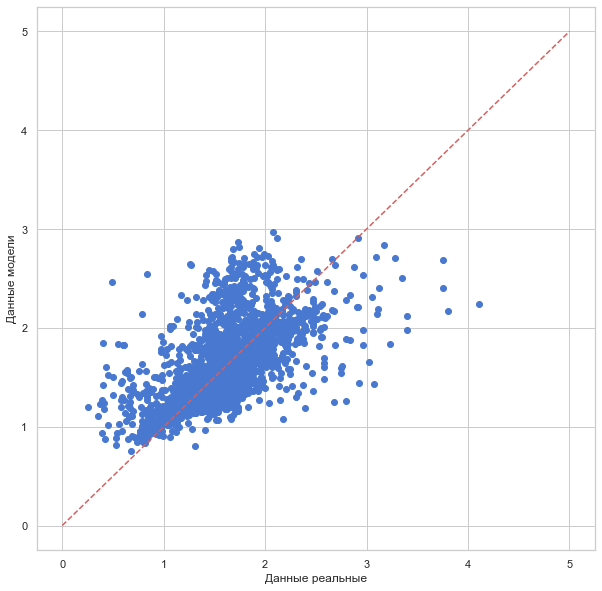

In [52]:
model_score(model, X_test, y_test)

In [53]:
pred_lm = clf.predict(X_test)
pred_cb = model.predict(X_test)

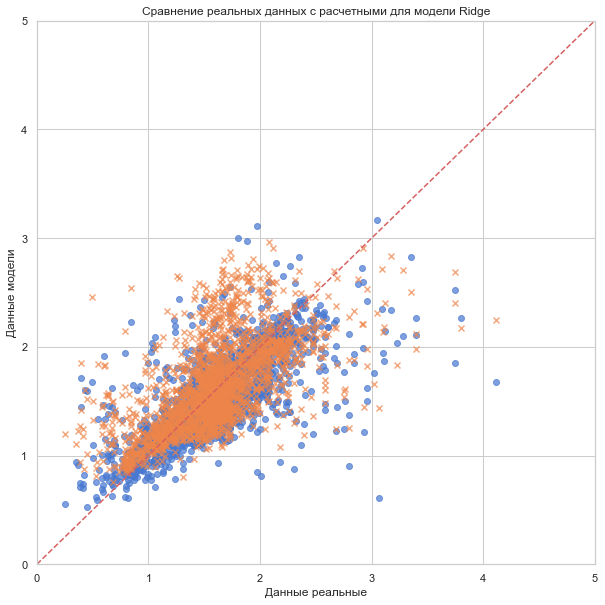

In [54]:
fig, main_ax = plt.subplots(figsize=(10, 10))

main_ax.scatter(y_test.values, pred_lm, alpha=0.7)
main_ax.scatter(y_test.values, pred_cb, marker='x', alpha=0.7)
scale = math.ceil(max(y_test.values.max(), pred_lm.max()))
main_ax.plot([0, scale], [0, scale], 'r--')

main_ax.set_xlim(0, scale)
main_ax.set_ylim(0, scale)

main_ax.set_title("Сравнение реальных данных с расчетными для модели Ridge")
main_ax.set_xlabel("Данные реальные")
main_ax.set_ylabel("Данные модели")

# ins_ax = fig.add_axes([0.64, 0.17, 0.25, 0.25])
# ins_ax.scatter(y_test.values, pred_lm, alpha=0.7)
# ins_ax.scatter(y_test.values, pred_cb, marker='x', alpha=0.7)
# ins_ax.set_xlim(0, 4)
# ins_ax.set_ylim(0, 4)
# ins_ax.plot([0, 4], [0, 4], 'r--')

plt.show()

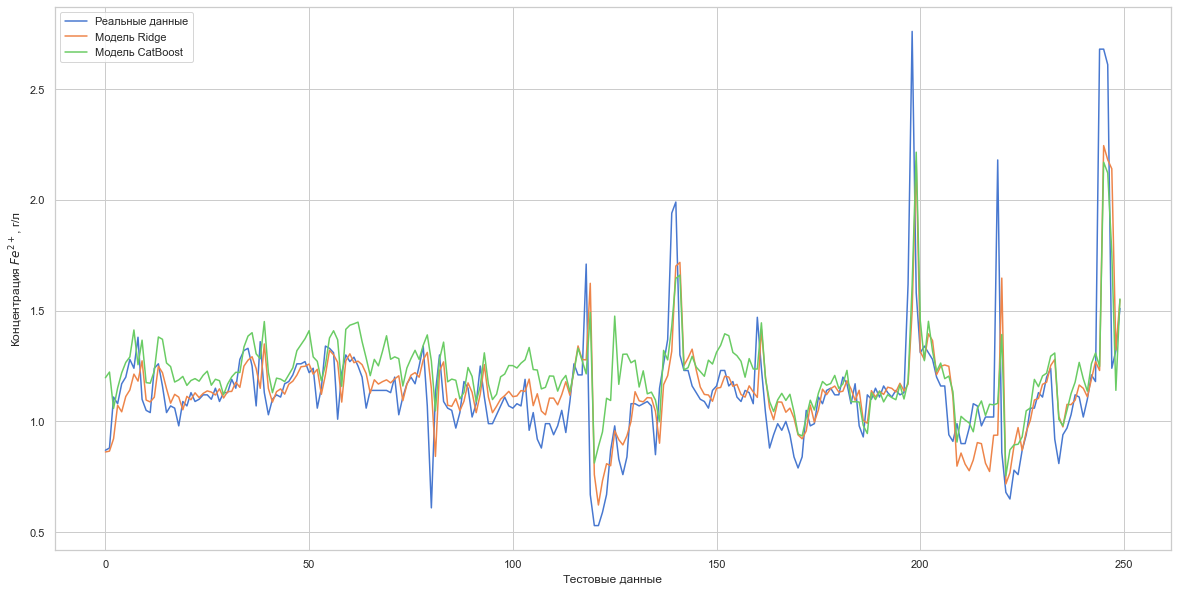

In [55]:
plt.figure(figsize=(20,10))

start = 1000
end = 1250

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_lm[start:end], label='Модель Ridge')
plt.plot(pred_cb[start:end], label='Модель CatBoost')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

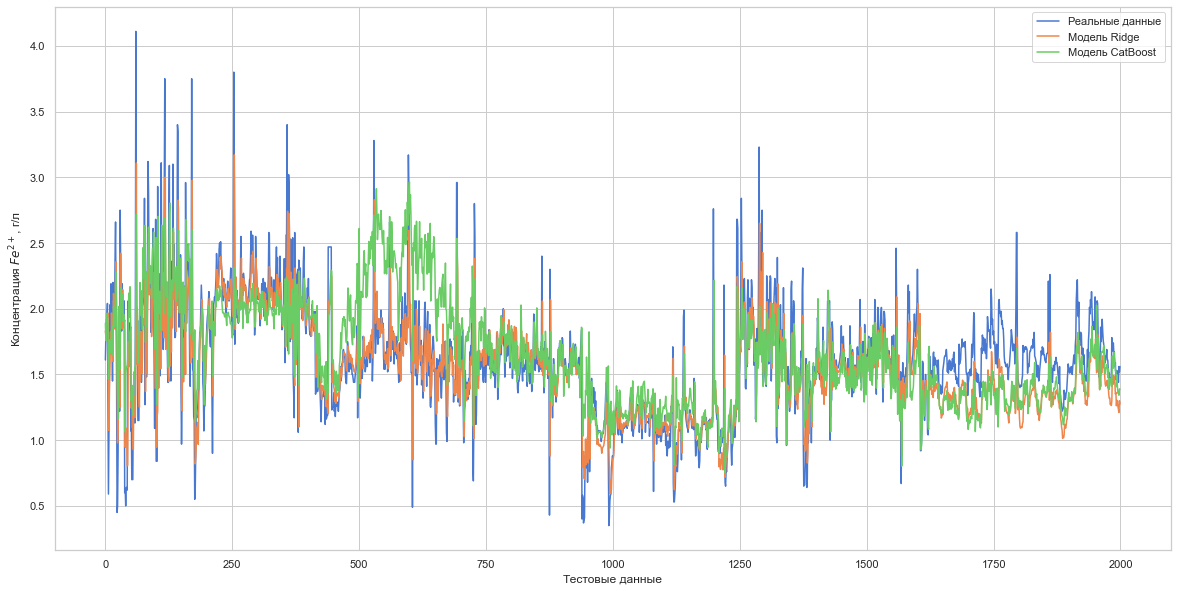

In [56]:
plt.figure(figsize=(20,10))

start = 0
end = 2000

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred_lm[start:end], label='Модель Ridge')
plt.plot(pred_cb[start:end], label='Модель CatBoost')
plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

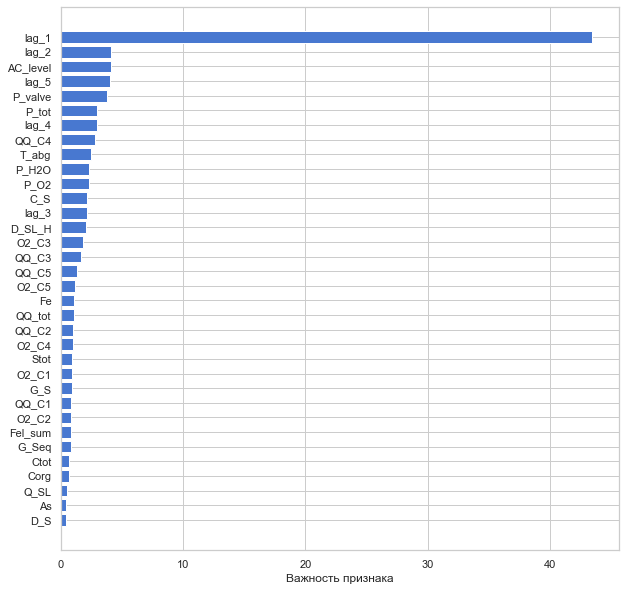

In [57]:
sorted_feature_importance = model.feature_importances_.argsort()

plt.figure(figsize=(10,10))
plt.barh(X_test.columns[sorted_feature_importance], model.feature_importances_[sorted_feature_importance])
plt.xlabel("Важность признака")
plt.show();